In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm

# Nível de Confiança e Valor P - visualizando a partir de simulações

Vamos ilustrar os testes de hipótese a partir de simulações, com o objetivo de entender o significado do p-valor (também relacionado ao nível de confiança discutido quando falamos de intervalo de confiança).

Vamos imaginar que queremos estimar o valor médio do preço de alugueis na cidade de Nova Iorque. Vamos carregar os dados:

In [40]:
df_raw = pd.read_csv(
    "https://www.kaggle.com/api/v1/datasets/download/ivanchvez/ny-rental-properties-pricing",
    compression="zip",
)

# vamos deixar apenas alugueis de imoveis inteiros
f = "Entire home/apt"
df = df_raw.query("room_type == @f")

df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
5,6,5238,Lower East Side,40.71344,-73.99037,Entire home/apt,150,86,1,161,1.29,1
8,9,6090,Manhattan,40.73530,-74.00525,Entire home/apt,120,226,180,27,0.22,271


Vamos ver quantos alugueis existem em nosso conjunto de dados, e armazenar a quantidade em uma variável chamada `n_imoveis`:

In [41]:
n_imoveis = df.shape[0]
df.shape

(9405, 12)

Vamos supor que esses dados contenham **todos** os aluguéis na cidade de Nova Iorque. Ainda, que o valor contido na coluna `price` é o valor diário do aluguel.

Vamos observar a distribuição dos valores:

<Axes: xlabel='price', ylabel='Count'>

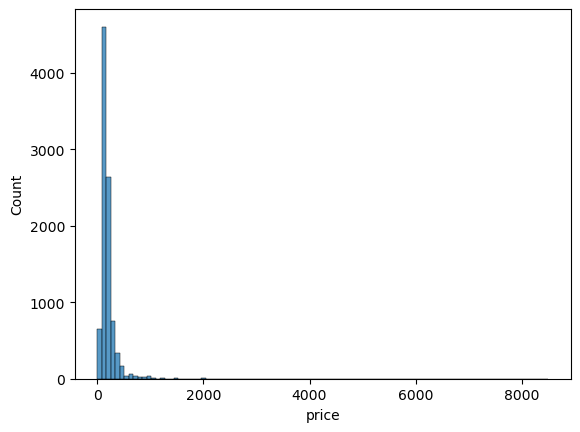

In [42]:
sns.histplot(df.price, bins=100)

Isso não se parece com uma distribuição normal. Temos uma longa calda à direita, com valores mais altos. Provavelmente seria explicado pela presença de imóveis de luxo, ou seja, com valores muito mais altos.

Vamos verificar o preço médio:

In [43]:
preco_medio = df["price"].mean()
preco_medio

197.7711855396066

Agora, vamos supor que precisamos fazer uma estimativa do preço médio de aluguel em Nova Iorque, e que não temos acesso a todos os dados. 

Nesse cenário, vamo considerar que temos capacidade de coletar informações sobre  uma amostra aleatória de 1000 imóveis, e obter o preço nessa amostra. Para simular isso, vamos usar o método `sample` do pandas, que nos permite selecionar aleatoriamente uma amostra de um DataFrame.

In [44]:
df_amostra = df.sample(n=1000)
# valor médio da amostra
print(df_amostra["price"].mean())
df_amostra.shape


200.231


(1000, 12)

Se fossemos calcular um intervalo de confiança para a média a partir dessa amostra, teríamos o seguinte intervalo para um nível de confiança de 95%:

In [45]:
intervalo_amostra = norm(
    df_amostra["price"].mean(),  # media
    df_amostra["price"].std() / (df_amostra.shape[0] ** 0.5),  # erro padrão
).interval(0.95)

intervalo_amostra

(189.15023335408827, 211.31176664591172)

Podemos verificar se o intervalo contém o valor médio da população:

In [46]:
if intervalo_amostra[0] <= preco_medio <= intervalo_amostra[1]:
    print("O preço médio da amostra está dentro do intervalo de confiança.")
else:
    print("O preço médio da amostra está fora do intervalo de confiança.")

O preço médio da amostra está dentro do intervalo de confiança.


Agora vamos simular o processo de coletar amostrar um grande número de vezes, calculando o intervalo de confiança para cada uma delas, e verificando se o intervalo contém o valor médio da população. Vamos usar uma função que calcula `n` amostras, e retorna um dataframe com os intervalos de confiança a um nível `conf` e se o intervalo contém o valor médio da população.

In [47]:
def gera_intervalos(df, n, conf, media_real):
    intervalos = []
    for i in range(n):
        amostra = df.sample(n=1000, replace=True)
        media = amostra["price"].mean()
        intervalo = norm(
            media,
            amostra["price"].std() / (amostra.shape[0] ** 0.5),
        ).interval(conf)
        if intervalo[0] <= media_real <= intervalo[1]:
            intervalos.append([media, intervalo[0], intervalo[1], True])
        else:
            intervalos.append([media, intervalo[0], intervalo[1], False])
    return pd.DataFrame(
        intervalos,
        columns=[
            "media_amostra",
            "limite_inferior_intervalo",
            "limite_superior_intervalo",
            "contem_media",
        ],
    )

Vamos testar quantas vezes o intervalo contém a média real se realizarmos 1000 amostras:

In [48]:
n_amostras = 1000
conf = 0.95

experimento_amostras = gera_intervalos(df, n_amostras, conf, preco_medio)
experimento_amostras.head()

,media_amostra,limite_inferior_intervalo,limite_superior_intervalo,contem_media
0,197.683,180.415819,214.950181,True
1,197.315,179.868221,214.761779,True
2,197.520,185.703881,209.336119,True
3,191.867,181.060166,202.673834,True
4,192.105,184.181904,200.028096,True


Vamos ver a proporção de intervalos que contém a média real:

In [49]:
experimento_amostras["contem_media"].value_counts()

contem_media
True     917
False     83
Name: count, dtype: int64

Ou em números relativos

In [50]:
experimento_amostras["contem_media"].value_counts(normalize=True)

contem_media
True     0.917
False    0.083
Name: proportion, dtype: float64

Podemos ver que no geral temos uma proporção próxima de 95% dos intervalos gerados contendo a média real!

Como discutimos, o nível de confiança se refere ao processo de calcular o intervalo de confiança, e não a um intervalo específico.


# Valor p

Agora, queremos usar a mesma estratégia (chamamos de simulação) para entender o valor p (ou p-valor, ou ainda p-value no inglês). O p-valor é uma estatística quase sempre reportada quando realizamos um teste de hipótese utilizando métodos estatísticos, incluindo o teste t.

Recapitulando, seu significado é a probabilidade de observarmos um resultado tão extremo quanto o observado, dado que a hipótese nula é verdadeira.

Vamos reformular a perspectiva de abordagem para o mesmo problema do preço dos alugueis. 

Com base informações anteriores, esperamos que o preço médio de alugueis em Nova Iorque seja de 197.77 dólares por dia, que é exatamente o valor que encontramos na média da população.

Queremos, com base em uma amostrar específica, testar a hipótese de que o preço médio dos alugueis é diferente de 197.77 dólares.

Nesse cenário temos a hipótese nula (H0) de que o preço médio dos alugueis é 197.77 dólares, e a hipótese alternativa (H1) de que o preço médio dos alugueis é diferente de 197.77 dólares.

Poderíamos realizar o teste t diretamente da primeira amostra original usando a função `ttest_1samp` do scipy, para quando temos apenas uma amostra e queremos testar se ela possui uma média diferente de um valor específico.

Vejamos:

In [51]:
from scipy.stats import ttest_1samp

# Teste de Hipóteses
# H0: a média da amostra é igual à média populacional
# H1: a média da amostra é diferente da média populacional
ttest_1samp(
    df_amostra["price"],
    preco_medio,
)

TtestResult(statistic=0.4350915333823646, pvalue=0.663589964874566, df=999)

A partir do valor p, qual o resultado desse teste?

Provavelmente, o resultado é de que não há diferença significativa entre a média da amostra e a média da população (`preco_medio`). Assim, muito provavelmente o resultado que observaremos é de um valor p maior que 0.05, o que nos leva a não rejeitar a hipótese nula.

Isso faz sentido, já que retiramos a amostra da população e calculamos sua média diretamente!

Mas vamos tentar entender isso a partir de nossa simulação. O teste de hipótese, por padrão, considera a chance de se observar uma diferença de magnitude igual ou maior que a observada, dado que a hipótese nula é verdadeira.

Ou seja, termos a diferença de valor entre a média da amostra e a média da população, seja para mais ou para menos. Podemos aproveitar os dados que geramos para visualizar isso:

In [52]:
# vamos ver a média de nossa amostra:
print(preco_medio)

# diferença entre a média da amostra e a média populacional
diferenca = df_amostra["price"].mean() - preco_medio
print(
    f"Observamos uma diferença de {diferenca:.2f} entre a média da amostra e a média populacional."
)

197.7711855396066
Observamos uma diferença de 2.46 entre a média da amostra e a média populacional.


Como podemos visualizar isso? Vamos aproveitar nossa simulação anterior, e gerar um gráfico para nosso problema.

<Axes: xlabel='media_amostra', ylabel='Count'>

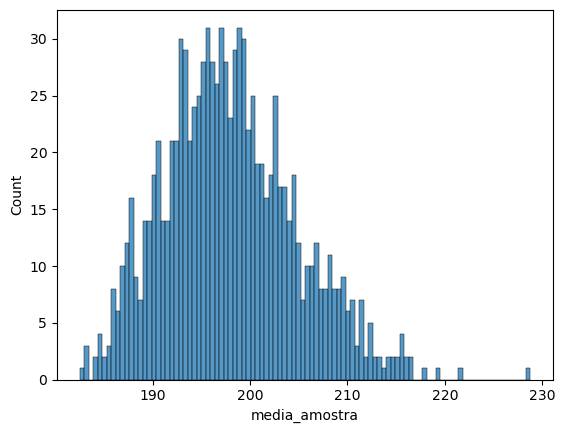

In [53]:
sns.histplot(x="media_amostra", data=experimento_amostras, bins=100)

Estamos interessados em observar o número de casos que estariam a distância observada ou maior, já que sabemos que esses dados foram gerados a partir de um cenário em que a hipótese nula é verdadeira.

Vamos adicionar a diferença observada visualmente no gráfico:

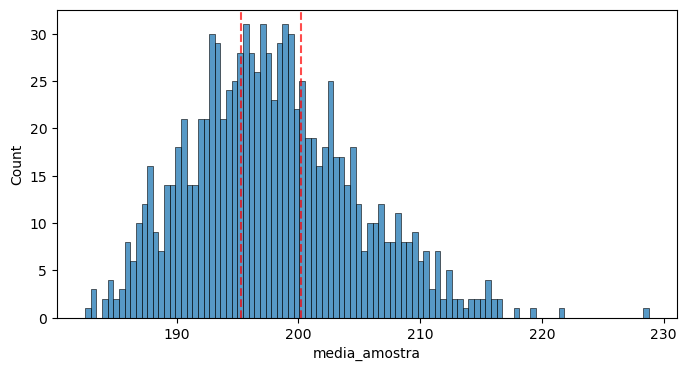

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(
    x="media_amostra",
    data=experimento_amostras,
    bins=100,
    ax=ax,
)

ax.axvline(
    x=preco_medio + diferenca,
    color="red",
    linestyle="--",
    alpha=0.7,
)

ax.axvline(
    x=preco_medio - diferenca,
    color="red",
    linestyle="--",
    alpha=0.7,
)


Ou destacando a área que representa o valor p:

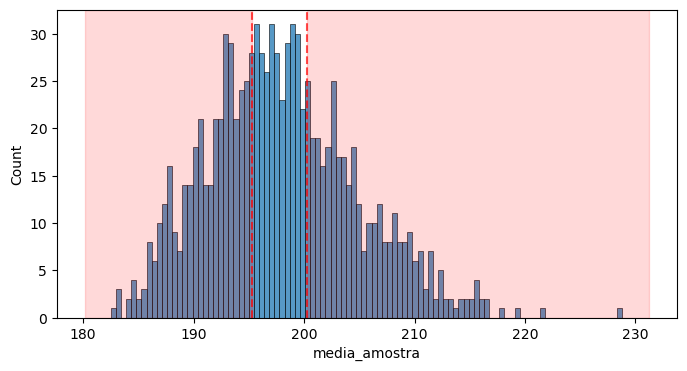

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(
    x="media_amostra",
    data=experimento_amostras,
    bins=100,
    ax=ax,
)


# fundo vermelho menor que a média
ax.axvspan(xmin=ax.get_xlim()[0], xmax=preco_medio - diferenca, color="red", alpha=0.15)

ax.axvline(
    x=preco_medio - diferenca,
    color="red",
    linestyle="--",
    alpha=0.7,
)

# fundo vermelho apos a média
ax.axvspan(xmin=preco_medio + diferenca, xmax=ax.get_xlim()[1], color="red", alpha=0.15)

ax.axvline(
    x=preco_medio + diferenca,
    color="red",
    linestyle="--",
    alpha=0.7,
)

Caso estivessemos resolvendo o problema por simulação, sem conhecer a distribuição da média, a estatística equivalente ao valor p seria a proporção de intervalos que estão a uma distância maior ou igual a diferença observada. Ou seja, o número de casos que estão para a esquerda da primeira linha vermelha, ou para a direita da segunda linha vermelha, dividido pelo número total de casos.

Podemos calcular isso facilmente a partir do dataframe que geramos anteriormente, e verificar o valor p:

In [56]:
limite_inferior = preco_medio - diferenca
limite_superior = preco_medio + diferenca

casos_dif = experimento_amostras.query(
    "media_amostra <= @limite_inferior or media_amostra >= @limite_superior"
)

print(casos_dif.shape[0])
valor_p_simulado = casos_dif.shape[0] / n_amostras
print(f"Valor p simulado: {valor_p_simulado:.4f}")


711
Valor p simulado: 0.7110


Assim, podemos ver de forma semelhante qual o significado do valor p! Escolhemos rejeitar a hipótese nula apenas quando houver uma chance considerada baixa de observamos um resultado como aquele, se a hipótese nula for verdadeira.

# Observações finais

O objetivo do notebook desta aula foi ilustrar o significado do p-valor e do nível de confiança, a partir de um exemplo usando simulação em que podemos sortear o valor de uma distribuição.

Como falamos nas aulas anteriores, a estatística nos garante a qualidade da aproximação a medida que o tamanho de nossa amostra aumenta. Além disso, o p-valor e o Nível de Confiança dizem respeito sobre o número de casos para um número infinito de amostragens, o que não é possível realizar mesmo com a simulação.

Assim, os valores observados de fato irão variar.

## Relação entre valor p e Nível de Confiança

Você provavelmente percebeu que parece haver uma relação entre o fato do valor p convencionado ser 0.05 e o nível de confiança de 95%.

De fato, esses valores estão diretamente ligados e são de certa forma complementares. Usamos um nível de confiança de 95% (0.95) a partir do fato que o valor p padrão é 0.05, ou seja, 5% de chance de observarmos um resultado tão extremo quanto o observado, dado que a hipótese nula é verdadeira.

Poderíamos também observar os valores cobertos por um intervalo de confiança.

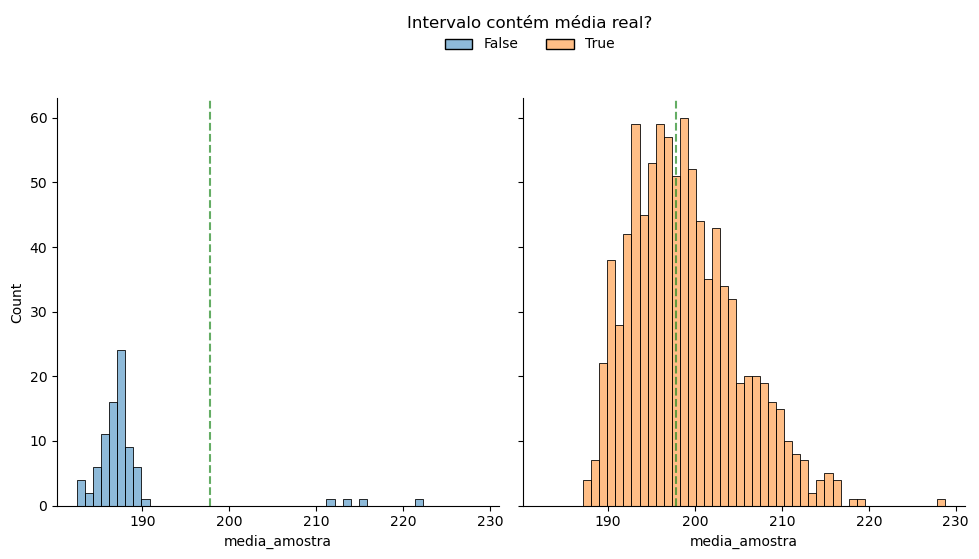

In [81]:
g = sns.displot(
    x="media_amostra",
    col="contem_media",
    hue="contem_media",
    data=experimento_amostras,
    bins=50,
)

g.set_titles(template="")

# adiciona média real
for ax in g.axes.flat:
    ax.axvline(
        x=preco_medio,
        color="forestgreen",
        linestyle="--",
        alpha=0.7,
    )

sns.move_legend(
    g,
    "lower center",
    title="Intervalo contém média real?",
    bbox_to_anchor=(0.48, 1),
    ncol=2,
    title_fontsize=12,
    fontsize=10,
)